In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from pandas_profiling import ProfileReport
import datetime as DT
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import pickle
from sklearn.cluster import KMeans
#import xgboost as xgb
#from xgboost.sklearn import XGBClassifier

In [4]:
#Reading the csv file to the dataframe
data_read=pd.read_csv("simpl_payments_bank_digicard_v1.0.csv")

## 1. Initial Data discovery and value treatment

In [5]:
#Describing the dataframe and it's attributes 
data_read.info()
data_read.describe()

##Pandas profiling for statistical insights snapshot of the initial dataset
profile = ProfileReport(data_read, title="Pandas Profiling Report")
profile


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 21 columns):
user_id                 45222 non-null object
gender                  45222 non-null object
date_of_birth           45222 non-null object
workclass               45222 non-null object
education_level         45222 non-null object
education_num           45222 non-null float64
marital_status          45222 non-null object
occupation              45222 non-null object
relationship            45222 non-null object
capital_gain            45222 non-null float64
capital_loss            45222 non-null float64
hours_per_week          45222 non-null float64
approved                45222 non-null int64
address                 45222 non-null object
email                   45222 non-null object
inquiry_purpose_code    43931 non-null float64
institute_type          45222 non-null object
account_type            45222 non-null int64
asset_class_cd          9492 non-null object
asset_code     

In [6]:
#Accessing the null values 
data_read['asset_code'].value_counts()

data_read['asset_class_cd'].value_counts()
# # #Hence in the 'asset_class_cd' column ,we will convert the '?' to unknown or'U' and -1/Nan's(blanks) to the default or 'de' as given in the manual 
data_read['asset_class_cd']=data_read['asset_class_cd'].replace({'?':'U','-1':'de'})
data_read['asset_class_cd'] = data_read['asset_class_cd'].fillna('de')

# #similarly for portfolio_type values
data_read[data_read['portfolio_type'].isna()]
data_read['portfolio_type'].value_counts()
# # And for the portfolio_type column, we convert the Nans value to R as our mode for that column is R
mode_portfolio_type=data_read['portfolio_type'].mode()
# #mode of that column is 'R' Since the automatic imputation is not working, we manually impute it.
data_read['portfolio_type'] = data_read['portfolio_type'].fillna('R')

##drop the inquiry purpose code value as it's not that correlated above .25 with approved variable
data_read = data_read[data_read['inquiry_purpose_code'].notna()]
#similarly for asset code
data_read=data_read[data_read['asset_code'].notna()]


#convert the float values to objects-
#columns to be converted- approved,inquiry_purpose_code,account_type,asset_code
#inquiry_purpose_code and asset_code to be converted to int first

data_read=data_read.astype({"inquiry_purpose_code": int,"asset_code":int})
#Convert the int values to str values for output as well as other categorical values which were intitially float values
data_read = data_read.astype({"approved": str, "inquiry_purpose_code": str,"account_type":str,"asset_code":str})

In [7]:
#Feature creation 
##We need age from the dob for any correlation graph between age and our dependent feature
now = pd.to_datetime('now')
data_read['date_of_birth']=pd.to_datetime(data_read['date_of_birth'])
data_read['age']=(now.year - data_read['date_of_birth'].dt.year) - ((now.month - data_read['date_of_birth'].dt.month) < 0)

## 2. Data description and distribution

1.For continous variable we see any relation with approved feature

2.We see age alone can give us the significant relationship between 25 to 50 years of person is more eligible for loan status

3.Then we see other continous variables and education_num which is education level has slightly high number of approved variables if it's between 8.5 to 12.

4.We can infer this more by plotting it with hours per week variable. But other variables alone can't give us the relationship we want.


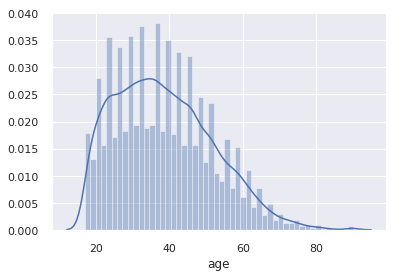

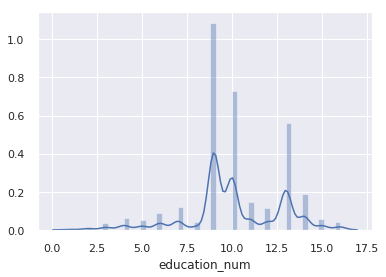

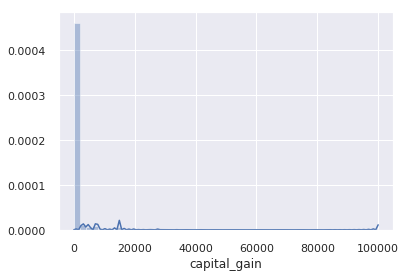

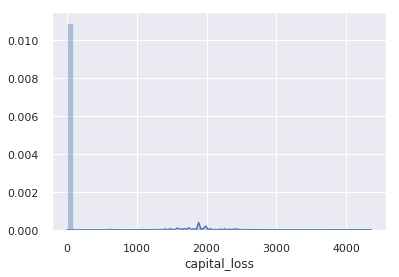

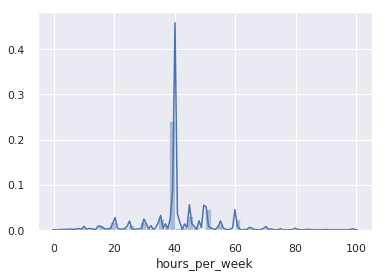

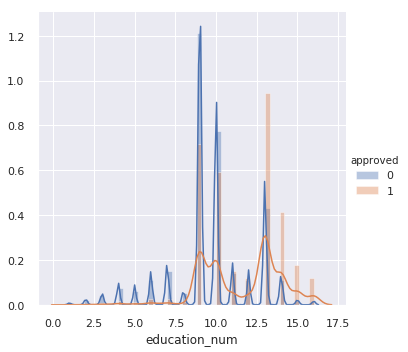

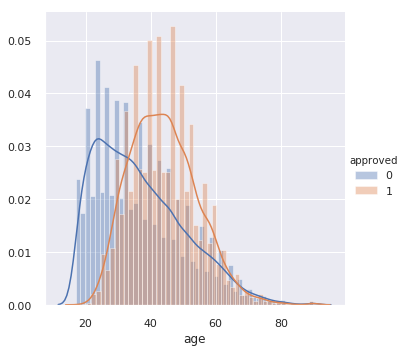

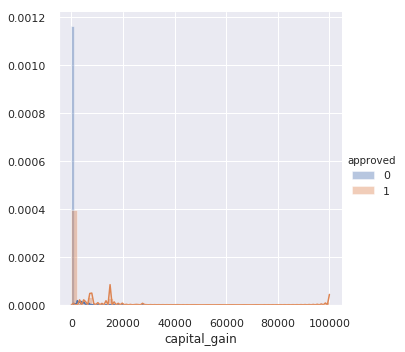

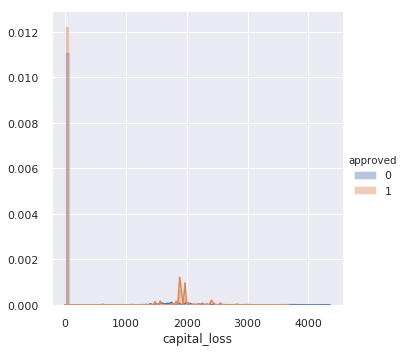

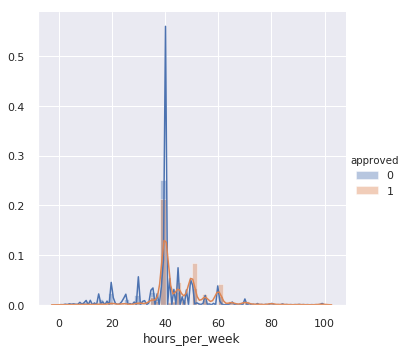

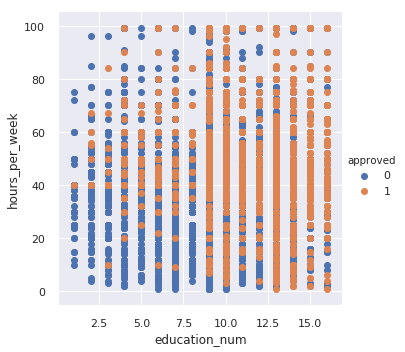

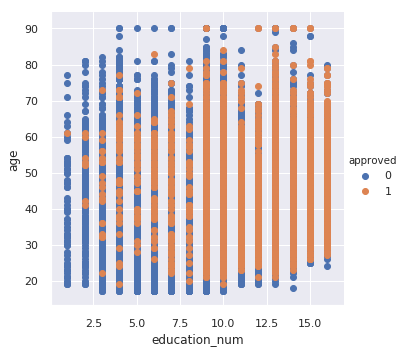

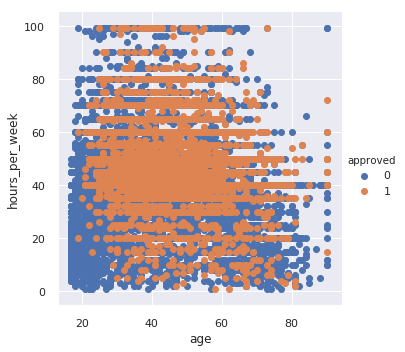

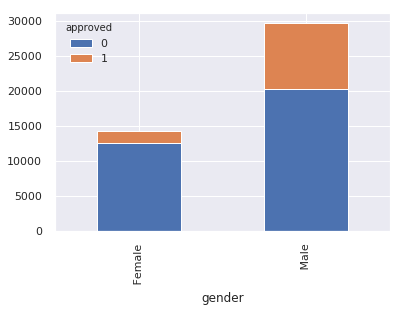

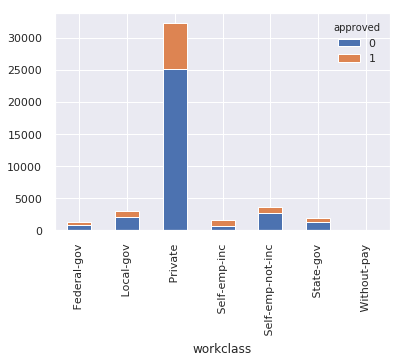

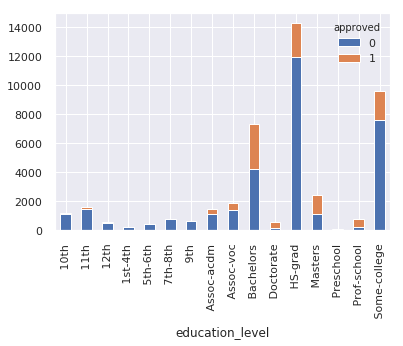

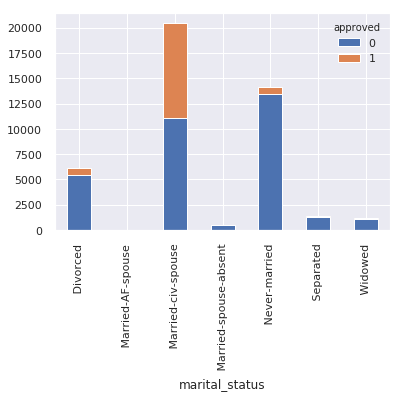

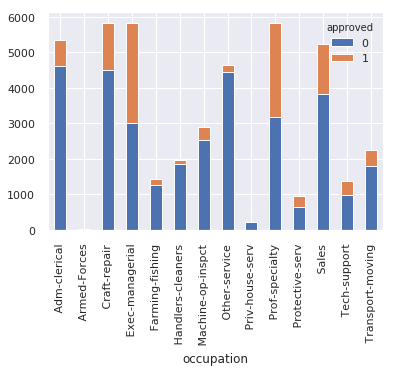

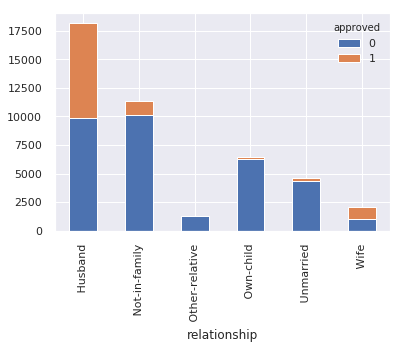

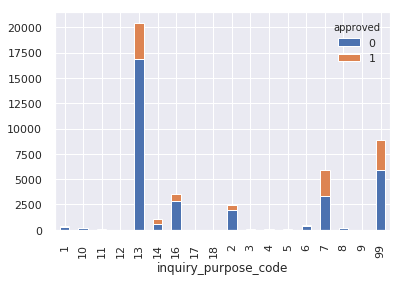

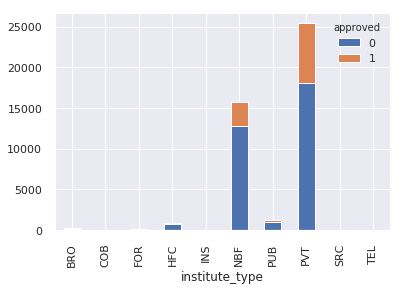

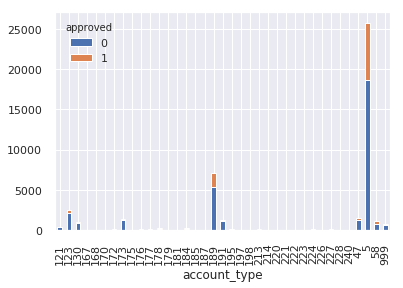

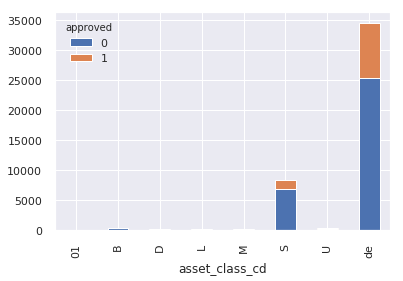

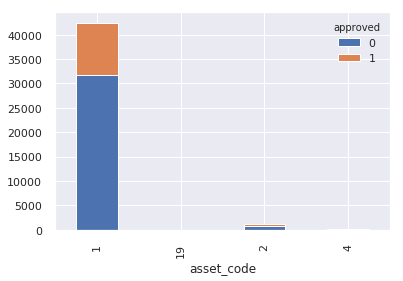

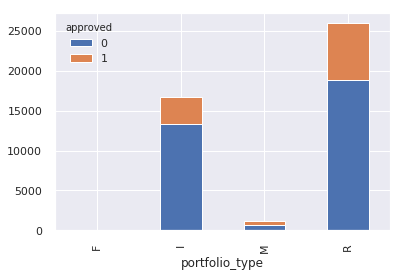

In [21]:

def plotDistPlot(col):
    """Flexibly plot a univariate distribution of observation"""
    sns.distplot(col)
    plt.show()
plotDistPlot(data_read['age'])
plotDistPlot(data_read['education_num'])
plotDistPlot(data_read['capital_gain'])
plotDistPlot(data_read['capital_loss'])
plotDistPlot(data_read['hours_per_week'])

def continous_graph(var):
    sns.set_style=("whitegrid");
    sns.FacetGrid(data_read,hue="approved",size=5)\
        .map(sns.distplot,var)\
        .add_legend();
    plt.show()

continous_graph("education_num")
continous_graph("age")
continous_graph("capital_gain")
continous_graph("capital_loss")
continous_graph("hours_per_week")


#We see the education level with variables like age and hours/week
def scatterplot(var1,var2):
    sns.set_style=("whitegrid");
    sns.FacetGrid(data_read,hue="approved",size=5)\
        .map(plt.scatter,var1,var2)\
        .add_legend();
    plt.show()
scatterplot("education_num","hours_per_week")    
scatterplot("education_num","age")
scatterplot("age","hours_per_week")

#For categorical variable
def create_graph(x,y):
    data_read.groupby([x,y]).size().unstack().plot(kind='bar',stacked=True)
    plt.show()

#Gender vs approved    
create_graph('gender','approved')

#Workclass vs approved
create_graph('workclass','approved')

#Educationlevel vs approved
create_graph("education_level","approved")

#Marital_Status vs approved
create_graph('marital_status','approved')

#occupation vs approved
create_graph('occupation','approved')

#relationship vs approved
create_graph('relationship','approved')

##inquiry purpose code vs approved
create_graph('inquiry_purpose_code','approved')

##institute_type va approved
create_graph('institute_type','approved')

#account type vs approved
create_graph('account_type','approved')

#asset_class_cs vs approved
create_graph('asset_class_cd','approved')

#asset_code vs approval
create_graph('asset_code','approved')

#portfolio_type vs approval
create_graph('portfolio_type','approved')


##Conclusions-

#1.Gender vs approved    

-The percentage of male applicants is slightly higher while getting their loan approved rather than the females.
-As number of male applicants are also higher in the dataset probably double and number of loan approval is rate is also 1/3
-So gender can be a variable that can be inferred.

#2.Workclass vs approved

-However in the case of workclass var, the total count is very high of "Private" class people hence the value of approved loans is also highest for them, but percentage to the approved to not approved is still lower, and in case of "skelf emolyed people ths ratio is much higher hence it affects the probability of self emolyedinc variable to be more eligible"
-And  for "self emolyed-not-inc" and state govt ,this ratio is very lower

#3.Educationlevel vs approved

-So the people with values bachelors,HS-Grad,Masters,Some college have higher count of values in the dataset,hence their ratio will be affected
-Apparently the odds of getting approved for bachelors is just half, while for 'H_S grad' and 'some college' this ratio is low,
-Meanwhile the 'masters ','doctorate',and 'prof-school' has higher probability of getting their credit approved.

#4.Marital_Status vs approved

-The total count of these values(Divorced,Married-civ-spouse,never married) is higher than rest of the  values.
-While the Married-Af-spuse is having the descent probability for approval and there is nearly half the odds that 'Married-civ-spouse' get the loan approved.
-And rest of the values has very less odds that they will get their approval

#5.occupation vs approved
-The odds of approval is high for Exec-managerial,Prof-speciality and Sales is slighlty higher than rest of the values

#6.relationship vs approved
-The odds are higher for married people for approval

#7.inquiry purpose code vs approved
-odds for credit_card(7) and personal loan(13) is higher

#8.institute_type va approved
-PVT and NBF has higher value counts but odds are not clearer

#9.account type vs approved
-Loan consumer and credit card has high odds of approval same as inquiry purpose code.

#10.asset_class_cs vs approved
-It will not gives us the predictive power because most of the values are default and blank

#11.asset_code vs approval
-individual and joint have high odds for getting approval

#12.portfolio_type vs approval
-Revolting Credit has higher chances but not clearer

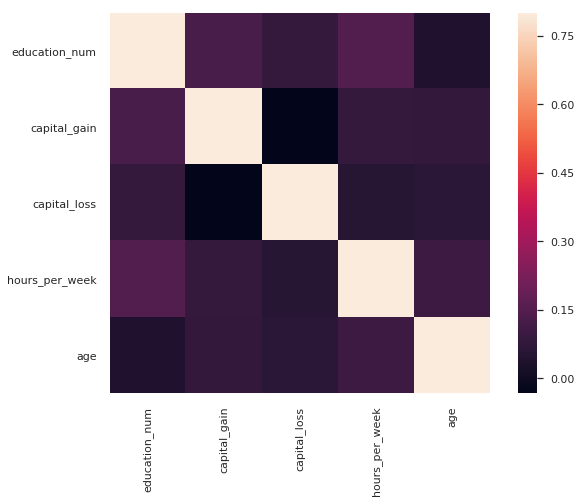

In [22]:
#correlation matrix
corrmat = data_read.corr()
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corrmat, vmax=.8, square=True);
#THere is no tight correlation between education_num with capital gain and hours_per week.It's near 15%.

## 3. Feature encoding and scaling

In [8]:
#Getting the shape of the dataset
print("shape of the data:", data_read.shape)

shape of the data: (43849, 22)


In [9]:
le = LabelEncoder()
# # Looping for each object type column
#Using label encoder to convert into numeric types
for col in data_read:
    if data_read[col].dtypes=='object':
        data_read[col]=le.fit_transform(data_read[col])

In [10]:
# Removing the feature which are not important and converting to NumPy array
data_read_o=data_read.copy()
data_read = data_read.drop(['user_id', 'date_of_birth','address','email'], axis=1)
df = data_read.values
df2=df.copy()

1. We remove the above 4 columns as they are not have any importance in the analysis
2. Then we split the target and rest of the variables 

In [11]:
#X and y for the target and independent variables
y=df[:,10]
#Removing the approved column by axis
df2=np.delete(df2,10,1)
X= df2[:,0:18]#Selecting all but the target

# Spliting the data into training and testing sets
X_train, X_test, y_train, Y_test = train_test_split(X,
                                y,
                                test_size=0.2,
                                random_state=123)


In [12]:
# Scaling X_train and X_test
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)

In [13]:
rescaledX = scaler.transform(X)

In [14]:
#We fit the RF classifier and view it's insights
rf = RandomForestClassifier(n_estimators=500)
rf.fit(rescaledX_train, y_train)
y_pred = rf.predict(rescaledX_test)
print("Random Forest classifier has accuracy of: ", rf.score(rescaledX_test, Y_test))
# Evaluate the confusion_matrix
confusion_matrix(Y_test, y_pred)
print(classification_report(Y_test,y_pred))

Random Forest classifier has accuracy of:  0.8604332953249715
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      6551
         1.0       0.75      0.67      0.71      2219

    accuracy                           0.86      8770
   macro avg       0.82      0.80      0.81      8770
weighted avg       0.86      0.86      0.86      8770



1. We got a decent amount of accuracy as well as the good score for precision and Recall.
- It means we have to focus on either Flse positives and False Negatives according to the business need.

2. If the goal here is to find "Claims not getting approved but in actual should be approved" we have to focus on reducing the false positives

3. And if the goal here is to find "Claims getting approved but in actual should not been have approved", we focus on reducing the False Negatives
- As far as regarding this use-case relatively the FN should be reduced.

Then we plot the feature importance to see which feature has better predictive power

Feature ranking:
1. feature 16 (0.168990)
2. feature 7 (0.111958)
3. feature 6 (0.109626)
4. feature 3 (0.098465)
5. feature 9 (0.087697)
6. feature 5 (0.076044)
7. feature 4 (0.073635)
8. feature 10 (0.058169)
9. feature 1 (0.043079)
10. feature 2 (0.034812)
11. feature 12 (0.034119)
12. feature 8 (0.033525)
13. feature 11 (0.026010)
14. feature 13 (0.013784)
15. feature 15 (0.012850)
16. feature 0 (0.011949)
17. feature 14 (0.005288)


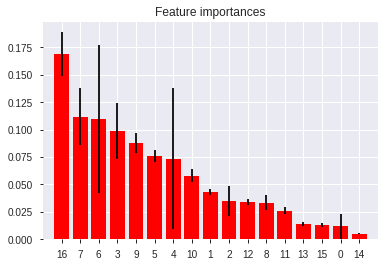

In [15]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

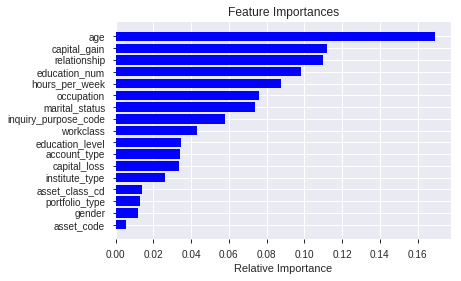

In [16]:
data_read_dup=data_read.copy()
data_read_dup = data_read_dup.drop(['approved'], axis=1)

features = data_read_dup.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

##So below are the important feature for predicting the approval of credit cards.

In [17]:
# Fitting logistic regression with default parameter values
logreg = LogisticRegression()
logreg.fit(rescaledX_train, y_train)

y_pred = logreg.predict(rescaledX_test)

# Getting the accuracy score of predictive model
print("Logistic regression classifier has accuracy of: ", logreg.score(rescaledX_test, Y_test))

# Evaluate the confusion_matrix
confusion_matrix(Y_test, y_pred)

print(classification_report(Y_test,y_pred))

Logistic regression classifier has accuracy of:  0.8222348916761688
              precision    recall  f1-score   support

         0.0       0.84      0.93      0.89      6551
         1.0       0.72      0.49      0.58      2219

    accuracy                           0.82      8770
   macro avg       0.78      0.71      0.74      8770
weighted avg       0.81      0.82      0.81      8770



1. We get slightly worse accuracy in case of logistic regression and considerably the precision and recall is decent.

2. So we try different parameters with grid search.
   But at the end we get better metrics in the case of Random Forest

In [18]:
y_probs = logreg.predict_proba(rescaledX)
y_class = logreg.predict(rescaledX)

In [141]:
y_probs = np.delete(y_probs, 0, 1)
data_read_o["Probs"] = np.ravel(y_probs).tolist()
data_read_o["Class"] = np.ravel(y_class).tolist()

In [19]:
#Outputting the data to csv
#Since the Random Forest perform better than all the tried models
y_probs = rf.predict_proba(rescaledX)
y_class = rf.predict(rescaledX)
y_probs = np.delete(y_probs, 0, 1)
data_read_o["Probs"] = np.ravel(y_probs).tolist()
data_read_o["Class"] = np.ravel(y_class).tolist()
data_read_o.to_csv("output_data_initial.csv", index = False)


In [144]:
# Define the grid of values for tol and max_iter
tol = [0.01, 0.001, 0.0001]
max_iter = [100, 150, 200]

# Create a dictionary
param_grid = dict(tol=tol, max_iter=max_iter)

In [145]:
# Initializing GridSearchCV
grid_model = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, cv=5)

# Rescaling the entire data set with all the predictive features
rescaledX = scaler.fit_transform(X)

# Calculating and summarizing the final results
grid_model_result = grid_model.fit(rescaledX, y)
best_score, best_params = grid_model_result.best_score_, grid_model_result.best_params_ 
print("Best: %f using %s" %  (best_score, best_params))


Best: 0.808092 using {'tol': 0.01, 'max_iter': 100}


In [149]:
#Using gradient boosting

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:

    gb = GradientBoostingClassifier(
      n_estimators=20, 
      learning_rate = learning_rate, 
      max_features=2, 
      max_depth = 2, 
      random_state = 0)
      
    gb.fit(rescaledX_train, y_train)
    
    print("Learning rate: ", learning_rate)
    print("Accuracy (training): {0:.3f}".format(gb.score(rescaledX_train, y_train)))
    print("Accuracy (validation): {0:.3f}".format(gb.score(rescaledX_test, Y_test)))
    print()

Learning rate:  0.05
Accuracy (training): 0.756
Accuracy (validation): 0.752

Learning rate:  0.1
Accuracy (training): 0.810
Accuracy (validation): 0.808

Learning rate:  0.25
Accuracy (training): 0.844
Accuracy (validation): 0.842

Learning rate:  0.5
Accuracy (training): 0.850
Accuracy (validation): 0.847

Learning rate:  0.75
Accuracy (training): 0.854
Accuracy (validation): 0.851

Learning rate:  1
Accuracy (training): 0.856
Accuracy (validation): 0.850



In [150]:
#So the best Learning rate is 0.75 we, try to predict and plot confusion matrix upon it
gb = GradientBoostingClassifier(
  n_estimators=20, 
  learning_rate = 0.5, 
  max_features=2, 
  max_depth = 2, 
  random_state = 0)

gb.fit(rescaledX_train, y_train)

predictions = gb.predict(rescaledX_test)

print("Confusion Matrix:")
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

Confusion Matrix:
[[6189  362]
 [ 981 1238]]


In [154]:
y_scores_gb = gb.decision_function(rescaledX_test)
fpr_gb, tpr_gb, _ = roc_curve(Y_test, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))
saved_model = pickle.dumps(gb)
saved_model_rf=pickle.dumps(rf)

#As random forest was the best until now.



Area under ROC curve = 0.91


In [ ]:
#Fitting with XGB,
#As XGB failed at my end due to system error. So I can't get the accuracy with it.
# params = {
#     'objective': 'binary:logistic',
#     'max_depth': 2,
#     'learning_rate': 1.0,
#     'silent': 1.0,
#     'n_estimators': 5
# }

# model = XGBClassifier(**params).fit(rescaledX_train, y_train)
# # predict the target on the train dataset
# predict_train = model.predict(rescaledX_train)
# print('\nTarget on train data',predict_train) 
 
# # Accuray Score on train dataset
# accuracy_train = accuracy_score(y_train,predict_train)
# print('\naccuracy_score on train dataset : ', accuracy_train)
 
# # predict the target on the test dataset
# predict_test = model.predict(rescaledX_test)
# print('\nTarget on test data',predict_test) 
 
# # Accuracy Score on test dataset
# accuracy_test = accuracy_score(Y_test,predict_test)
# print('\naccuracy_score on test dataset : ', accuracy_test)


# 2nd Task For segmenting the prices based on the approved loans

1. We will just use the outp

In [19]:
segment_data=pd.read_csv('output_data_initial.csv')


In [20]:
segment_data['approved'].value_counts()
rslt_df = segment_data[segment_data['approved'] == 1] 

In [21]:
le = LabelEncoder()
# # Looping for each object type column
#Using label encoder to convert into numeric types
for col in rslt_df:
    if rslt_df[col].dtypes=='object':
        rslt_df[col]=le.fit_transform(rslt_df[col])

In [24]:
#rslt_df_copy=rslt_df.copy()
rslt_df = rslt_df.drop(['user_id', 'date_of_birth','approved','Probs','Class','address','email'], axis=1)
x = rslt_df.values
x2=x.copy()


In [25]:
#Scaling the variables
min_max_scaler =MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
rslt_df = pd.DataFrame(x_scaled,columns=rslt_df.columns)

There are a number of techniques that can be used to find the optimal number. For this example, I am going to use the elbow method so named because the chart that it produces is similar in shape to the curve of an elbow. This method computes the sum of squared distances for clusters k. As more clusters are used the variance will reduce until you reach a point at which increasing clusters no longer results in a better model. 

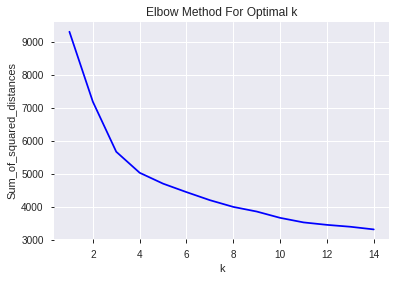

In [26]:
#Seeing the elbow method

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(rslt_df)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
#We can see that optimum cluster 4 to 5 would be better

In [27]:
#Dividing train and test split by 80-20 ratio
np.random.seed(0)
msk = np.random.rand(len(rslt_df)) < 0.8
train = rslt_df[msk]
test = rslt_df[~msk]

X = np.array(train)
X_test = np.array(test)

kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
y_k = kmeans.predict(X_test)
test['PREDICTED_CLUSTER'] = y_k

In [28]:
#Summarizing the results
train_summary = test.groupby(by='PREDICTED_CLUSTER').mean()
train_summary = train_summary[['gender', 'workclass', 
                               'education_level','education_num', 
                               'marital_status', 
                              'occupation','relationship', 
                               'capital_gain','capital_loss','hours_per_week','inquiry_purpose_code','institute_type','account_type','asset_class_cd','asset_code','portfolio_type','age']]
train_summary

1. On the top of approved credits we can identify the credit limit according to the clusters, the one with cluster 0 and 1 have higher education level,higher capital_gain  and are married.

2. But on the other hand there is also a probabilty of assigning higher credit limit to the cluster 1 and 2 with good occupation,account type, with considerable amount of assets possesed.
 
3. So it will be the decision of business ultimately to give credit accordingly if they are willing to see the credit history and occupation bottom clusters would be preferred. And if they prefer educational background, upper clusters would be the limits.
And Limit can be divided according to the clusters.

In [49]:
test.to_csv("segements.csv", index = False)